In [ ]:
# torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.transforms import transforms
import torch.optim as optim
# utils
import os
from glob import glob
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
# visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, confusion_matrix

In [ ]:
# global variables
device = "cuda" if torch.cuda.is_available() else "cpu"
#dataset_path = "/kaggle/input/brain-tumor-mri-dataset"
train_path = "Train_Images"
test_path = "Test_Images"
image_size = (224,224)
num_classes = 5
train_paths = glob(f"{train_path}/*/*.png")
test_paths = glob(f"{test_path}/*/*.png")
# check device
device

'cpu'

In [ ]:
# data augmentation
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
# custom dataset class
class dataset(Dataset):
    def __init__(self,paths,transform=None):
        self.paths = paths
        self.transform = transform
        self.labels = [self.get_label(path) for path in self.paths]
        self.labels_to_index = {label:index for index,label in enumerate(list(set(self.labels)))}
    
    def __getitem__(self,index):
        img_path = self.paths[index]
        img = Image.open(img_path).convert('RGB') 
        label = self.labels[index]
        label_index = self.labels_to_index[label]
        
        if self.transform:
            img = self.transform(img)
        
        return img, label_index,label
    
    
    def __len__(self):
        return len(self.paths)
    
    
    def get_label(self, path):
        return os.path.basename(os.path.dirname(path))


In [ ]:
train_dataset = dataset(train_paths, transform=train_transform)
test_dataset = dataset(test_paths, transform=test_transform)
val_dataset, test_dataset = train_test_split(test_dataset,test_size=0.5)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
class MyModel(nn.Module):
    def __init__(self,num_classes):
        super(MyModel,self).__init__()
        
        self.conv1 = nn.Conv2d(3,32,kernel_size=4,stride=1,padding=0)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32,64,kernel_size=4,stride=1,padding=0)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64,128,kernel_size=4,stride=1,padding=0)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(128,128,kernel_size=4,stride=1,padding=0)
        self.bn4 = nn.BatchNorm2d(128)
        
        self.pool = nn.MaxPool2d(kernel_size=3, stride=3)
        self.pool2= nn.MaxPool2d(kernel_size=3, stride=2)
        
        self.fc1 = nn.Linear(6*6*128,512)
        self.fc2 = nn.Linear(512,num_classes)
        
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU() 
        self.dropout = nn.Dropout(0.5)
        
        
        
        
    def forward(self,x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.pool2(x)
        x = self.relu(self.bn4(self.conv4(x)))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
model = MyModel(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.0002)

In [ ]:
def train_epoch():
    model.train()
    total_loss = 0.0 
    total_correct = 0
    total_predictions = 0
    
    for batch_number, (images, labels_indices, labels) in enumerate(train_loader):
        images, labels_indices = images.to(device), labels_indices.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, labels_indices)
        total_loss += loss.item()
        
        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total_predictions += labels_indices.size(0)
        total_correct += (predicted == labels_indices).sum().item()
        
        loss.backward()
        optimizer.step()
        
        if (batch_number and batch_number % 150 == 0):
            c_loss = total_loss / (batch_number + 1)
            accuracy = total_correct / total_predictions
            print(f"Batch {batch_number}/{len(train_loader)}, Loss: {c_loss:0.4f}, Accuracy: {accuracy * 100:.2f}%")
    
    avg_loss = total_loss / len(train_loader)
    avg_accuracy = total_correct / total_predictions
    
    return avg_loss, avg_accuracy

In [ ]:
def eval_model():
    model.eval()
    total_loss = 0.0 
    total_correct = 0
    total_predictions = 0
    
    with torch.no_grad():
        for batch_number, (images, labels_indices, labels) in enumerate(val_loader):
            images, labels_indices = images.to(device), labels_indices.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels_indices)
            total_loss += loss.item()
            
            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total_predictions += labels_indices.size(0)
            total_correct += (predicted == labels_indices).sum().item()
            
    avg_loss = total_loss / len(val_loader)
    avg_accuracy = total_correct / total_predictions
    
    return avg_loss, avg_accuracy

In [ ]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

Epoch 0,   Train Loss: 0.5601, Train Accuracy: 78.05%
Eval Loss: 0.6161, Eval Accuracy: 77.71%
######################################################################
Epoch 1,   Train Loss: 0.3593, Train Accuracy: 86.78%
Eval Loss: 0.4609, Eval Accuracy: 83.21%
######################################################################
Epoch 2,   Train Loss: 0.2706, Train Accuracy: 89.85%
Eval Loss: 0.4440, Eval Accuracy: 84.27%
######################################################################
Epoch 3,   Train Loss: 0.2430, Train Accuracy: 90.81%
Eval Loss: 0.4567, Eval Accuracy: 84.43%
######################################################################
Epoch 4,   Train Loss: 0.2118, Train Accuracy: 91.96%
Eval Loss: 0.3025, Eval Accuracy: 86.41%
######################################################################
Epoch 5,   Train Loss: 0.1765, Train Accuracy: 93.80%
Eval Loss: 0.2459, Eval Accuracy: 90.69%
######################################################################
Epoc

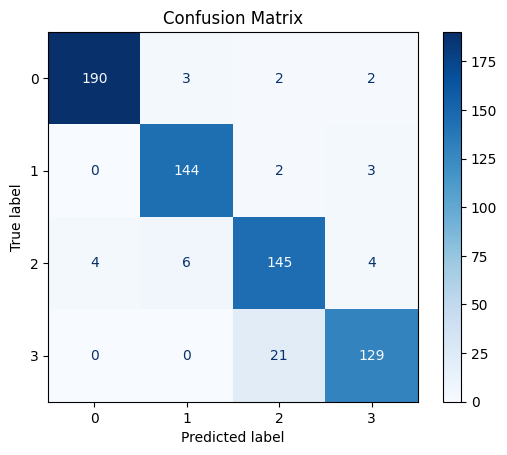

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming these lists are defined somewhere in your code
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []


best_score = float("inf")
n_epochs = 10
tolerance = 0

def train_epoch():
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    
    for batch in train_loader:
        data = batch[0].to(device)
        labels = batch[1].to(device)
        
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct_predictions += torch.sum(preds == labels).item()
        total_predictions += labels.size(0)
        
    avg_loss = running_loss / len(train_loader)
    accuracy = correct_predictions / total_predictions
    
    return avg_loss, accuracy

def eval_model():
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    
    with torch.no_grad():
        for batch in val_loader:
            data = batch[0].to(device)
            labels = batch[1].to(device)
            
            outputs = model(data)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_predictions += torch.sum(preds == labels).item()
            total_predictions += labels.size(0)
            
    avg_loss = running_loss / len(val_loader)
    accuracy = correct_predictions / total_predictions
    
    return avg_loss, accuracy

def get_predictions_and_labels():
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in val_loader:
            data = batch[0].to(device)  # Adjust based on the number of items your DataLoader returns
            labels = batch[1].to(device)
            outputs = model(data)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_preds, all_labels

for epoch in range(n_epochs):
    print(f"Epoch {epoch},   ", end="")
    avg_train_loss, train_accuracy = train_epoch()
    avg_eval_loss, eval_accuracy = eval_model()
    
    if avg_eval_loss < best_score:
        best_score = avg_eval_loss
        torch.save(model.state_dict(), f"model_{epoch+1}.pt")
        tolerance = 0
    else:
        tolerance += 1
        if tolerance >= 8:
            break
            
    train_losses.append(avg_train_loss)
    val_losses.append(avg_eval_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(eval_accuracy)
    
    print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy * 100:.2f}%")
    print(f"Eval Loss: {avg_eval_loss:.4f}, Eval Accuracy: {eval_accuracy * 100:.2f}%")
    print("#" * 70)

# Generate predictions and true labels
preds, true_labels = get_predictions_and_labels()

# Compute confusion matrix
cm = confusion_matrix(true_labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


Predicted class: meningioma


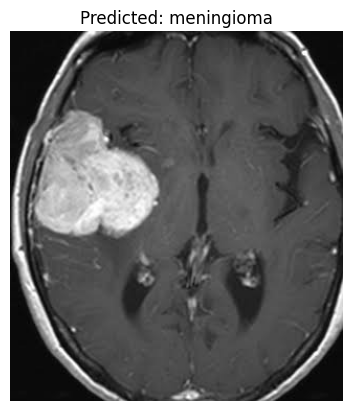

In [ ]:
# imports
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# global variables
device = "cuda" if torch.cuda.is_available() else "cpu"
image_size = (224, 224)
num_classes = 4
model_path = "/kaggle/working/model_8.pt"

# Load the model definition (should match the definition used during training)
class MyModel(nn.Module):
    def __init__(self, num_classes):
        super(MyModel, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=4, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=1, padding=0)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(128, 128, kernel_size=4, stride=1, padding=0)
        self.bn4 = nn.BatchNorm2d(128)
        
        self.pool = nn.MaxPool2d(kernel_size=3, stride=3)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        
        self.fc1 = nn.Linear(6 * 6 * 128, 512)
        self.fc2 = nn.Linear(512, num_classes)
        
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU() 
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.pool2(x)
        x = self.relu(self.bn4(self.conv4(x)))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Load the trained model
model = MyModel(num_classes).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# Define the image transformations
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Function to predict the class of a single image
def predict(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image)
    image = image.unsqueeze(0).to(device)
    
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
        
    return predicted.item()

# Define the label dictionary (adjust according to your dataset)
label_dict = {0: "notumor", 1: "glioma", 2: "meningioma", 3: "pituitary"}

# Example usage
image_path = "/kaggle/input/brain-tumor-mri-dataset/Testing/meningioma/Te-me_0025.jpg"  # Replace with the path to your image
predicted_class = predict(image_path)
predicted_label = label_dict[predicted_class]

print(f"Predicted class: {predicted_label}")

# Display the image with the prediction
image = Image.open(image_path)
plt.imshow(image)
plt.title(f"Predicted: {predicted_label}")
plt.axis('off')
plt.show()
